In [1]:
from pathlib import Path

from rljax.algorithm import DQN
from rljax.trainer import Trainer
import numpy as np
import pandas as pd

from classes import Env, Preprocess

PATH = Path().cwd()

In [2]:
raw = Preprocess(PATH.joinpath('asset_data', 'TBT_TBF_data.csv'), residual_num=7)
data = raw.process()

In [3]:
def return_rewards(current, last, action, p, c):
    return sum(current) - sum(last)

In [4]:
# 23,400 seconds between 9:30am and 4pm broken in 10 second increments

NUM_AGENT_STEPS = 150_000
SEED = 0
DAYS = 1
DAY = 2340//2

env = Env(data, no_trade_period=5, fixed_buy_cost=0.005, fixed_sell_cost=0.005, steps=DAY*DAYS, reward_func=return_rewards)
env_test = env.copy_env()

algo = DQN(
    num_agent_steps=NUM_AGENT_STEPS,
    state_space=env.observation_space,
    action_space=env.action_space,
    seed=SEED,
    batch_size=256,
    start_steps=1000,
    update_interval=1,
    update_interval_target=400,
    eps_decay_steps=0,
    loss_type="l2",
    lr=5e-5,
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    log_dir="",
    num_agent_steps=NUM_AGENT_STEPS,
    eval_interval=25_000,
    seed=SEED,
)
trainer.train()

Num steps: 25000    Return: -0.1    Time: 0:05:35
Num steps: 50000    Return: 0.0     Time: 0:11:28
Num steps: 75000    Return: -0.7    Time: 0:17:04
Num steps: 100000   Return: -1.7    Time: 0:22:16
Num steps: 125000   Return: 2.1     Time: 0:27:10
Num steps: 150000   Return: -3.8    Time: 0:31:42


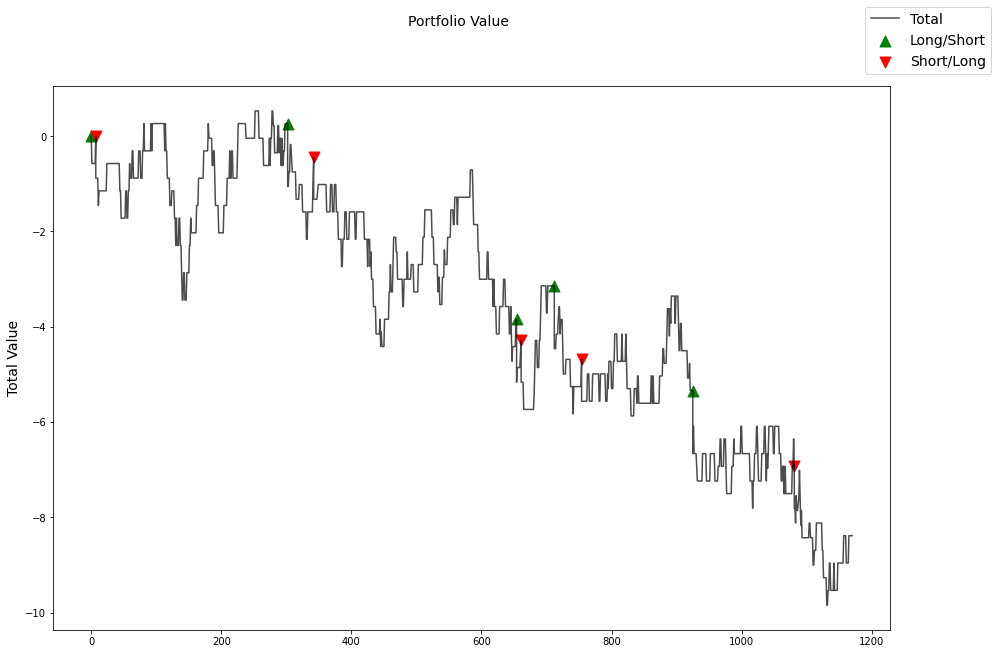

In [5]:
env.plot(fig_name='train_env_pnl_full_cost_dqn_9_242728')

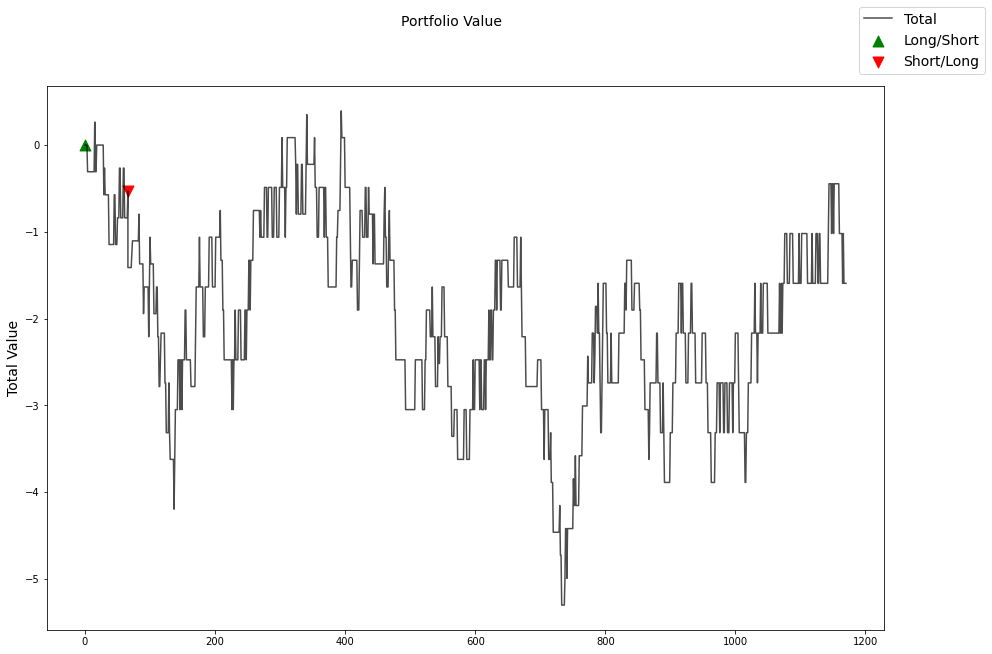

In [6]:
env_test.plot(fig_name='test_env_pnl_full_cost_dqn_9_242728')

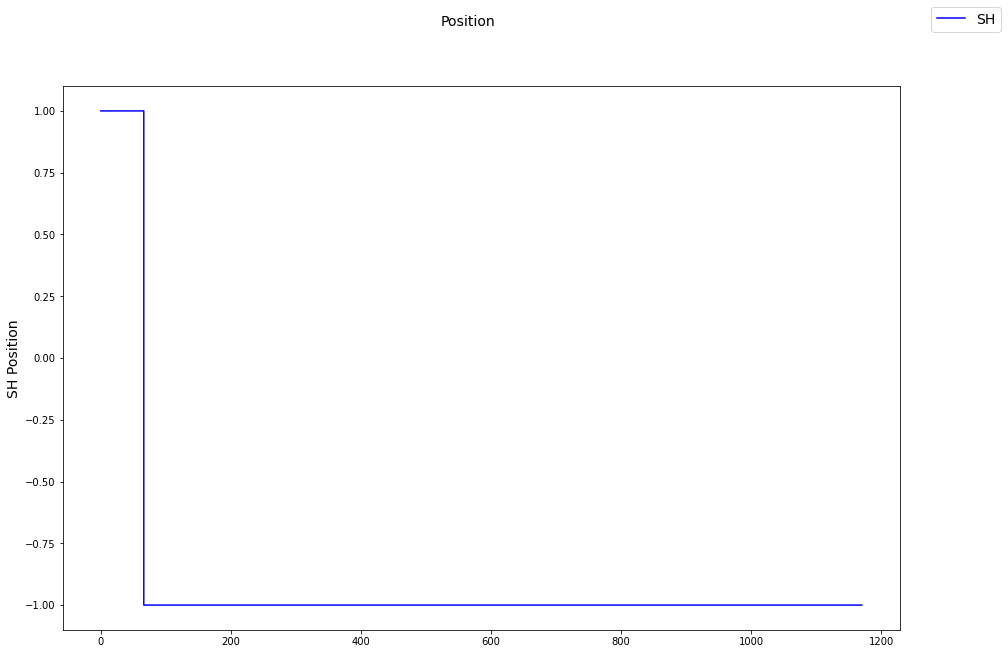

In [7]:
env_test.plot('position_history', fig_name='test_env_positions_full_cost_dqn_9_242728')

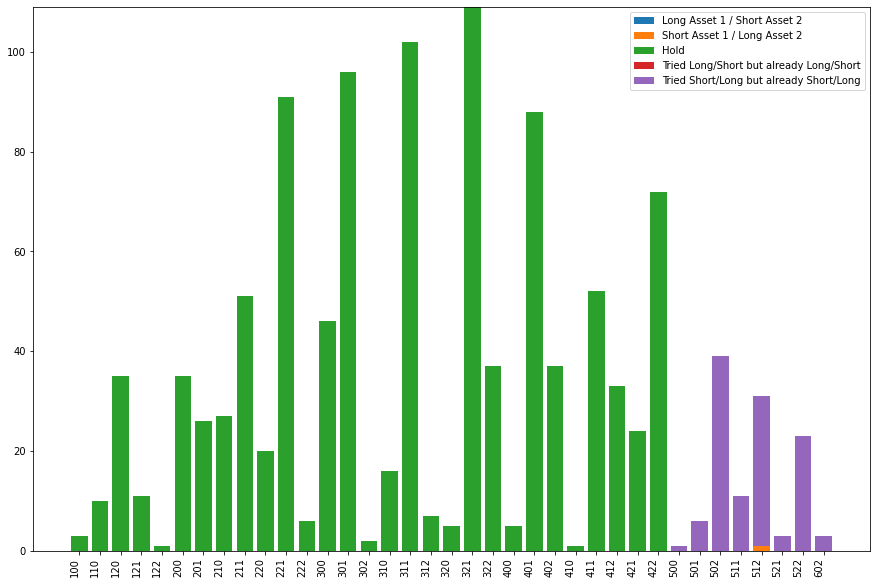

<Figure size 432x288 with 0 Axes>

In [8]:
env_test.summarize_decisions(fig_name='test_env_decisions_full_cost_dqn_9_242728')